# Exploring Saliency Maps

In [1]:
import os
os.chdir('02514-Deep-Learning-In-Computer-Vision/hotdog/')

In [2]:

import torch
from utils import *
from dataloader import *
from classifier import *
from torchvision.models import resnet18
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.io.image import read_image
from torchcam.utils import overlay_mask
from torchcam.methods import SmoothGradCAMpp, LayerCAM
from PIL import Image

In [3]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [9]:
#classifier = HotdogClassifier(model='SimpleCNN', use_wandb=False)
#model = classifier.model
#model.load_state_dict(torch.load('run_2023-06-06_10-37-27.pth'))
#model.eval().to(device)
#print(model)

# create classifier
#model = "Resnet18"
#model = "SimpleCNN"
model = "PeetzCNN_three"
#trained_model = "wandb:deepcomputer/HotdogModels/Resnet_finetune_model:v9"
trained_model = "wandb:deepcomputer/Hotdog/run_2023-06-07_12-50-27_model:latest"
trained_model = "wandb:deepcomputer/Hotdog/run_2023-06-07_11-28-12_model:v19"
trained_model = "wandb:eepcomputer/Hotdog/run_2023-06-07_13-44-28_model"
#trained_model = "wandb:deepcomputer/grid_search/run_2023-06-07_09-59-51_model:v7"
classifier = HotdogClassifier(model = model, use_wandb=False)
classifier.load_model(trained_model)
#classifier.model.load_state_dict(torch.load('run_2023-06-06_10-37-27.pth'))
#classifier.model.eval().to(device)
print(classifier.model)

Setting model to PeetzCNN_three
Loading model from wandb:deepcomputer/Hotdog/run_2023-06-07_11-28-12_model:v19


wandb: Downloading large artifact run_2023-06-07_11-28-12_model:v19, 64.99MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.5


PeetzCNN_threee(
  (convolutional): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Dropout(p=0.5, inplace=False)
  )
  (batchnorm_layer): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fully_connected): Sequential(
    (0): Linear(in_features=32768, out

In [7]:
for data, labels in classifier.test_loader:
    images = data_to_img_array(inverse_normalize(data))

In [54]:
# Set your CAM extractor
cam_extractor = SmoothGradCAMpp(classifier.model, target_layer="convolutional") # layer 4 is the last conv layer of the model
# get your input
img0 = Image.fromarray(images[0].astype('uint8'))
input_tensor = data[0].unsqueeze(0).to(device)

out = classifier.model(input_tensor)
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)


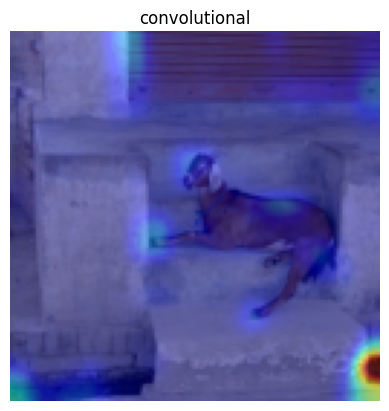

In [55]:
img = Image.fromarray(images[0].astype('uint8'))
for name, cam in zip(cam_extractor.target_names, cams):
  result = overlay_mask(img, to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
  plt.imshow(result); plt.axis('off'); plt.title(name); plt.show()
cam_extractor.remove_hooks()

IndexError: index 6 is out of bounds for axis 0 with size 6

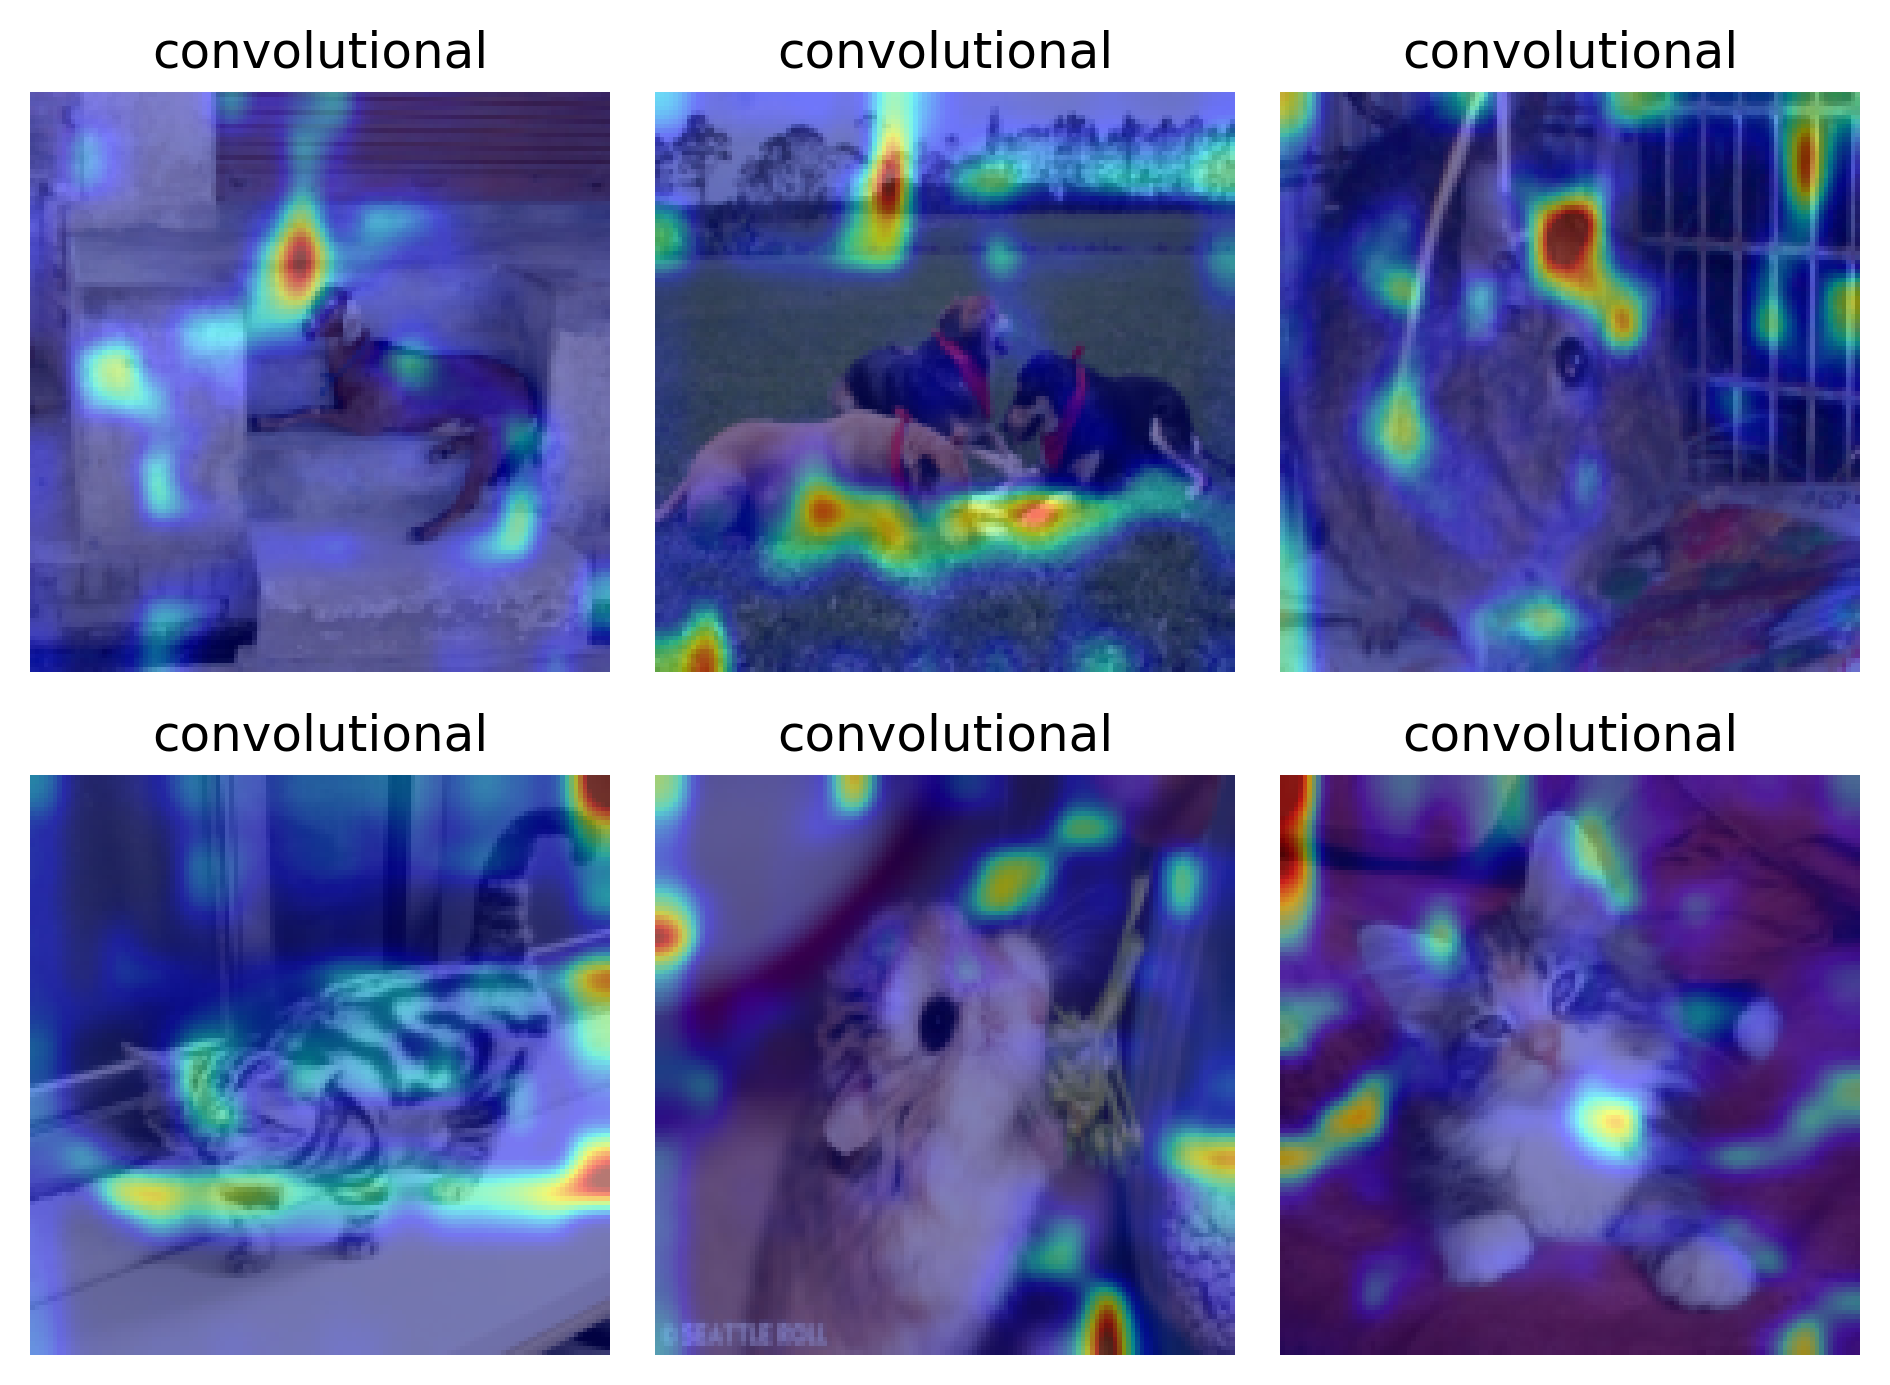

In [61]:
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
cam_extractor = SmoothGradCAMpp(classifier.model, target_layer='convolutional')
fig, ax = plt.subplots(2,3, dpi=300, tight_layout=True)
ax = ax.ravel()
for i, img in enumerate(data):
    imgo = Image.fromarray(images[i].astype('uint8'))
    #input_tensor = preprocess(imgo)
    input_tensor = img
    input_batch = input_tensor.unsqueeze(0).to(device)

    out = classifier.model(input_batch)
    cams = cam_extractor(out.squeeze(0).argmax().item(), out)

    for name, cam in zip(cam_extractor.target_names, cams):
        result = overlay_mask(imgo, to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
        ax[i].imshow(result); ax[i].set_axis_off(); ax[i].set_title(name);
cam_extractor.remove_hooks()
     


In [10]:
test_acc, test_loss, conf_mat = classifier.test(save_images = 10)
tp_imgs = data_to_img_array(inverse_normalize(classifier.test_images["true_positive"]))
fp_imgs = data_to_img_array(inverse_normalize(classifier.test_images["false_positive"]))
fn_imgs = data_to_img_array(inverse_normalize(classifier.test_images["false_negative"]))
tn_imgs = data_to_img_array(inverse_normalize(classifier.test_images["true_negative"]))

data = classifier.test_images["true_positive"]

Performing test with 1862 images
Accuracy test: 64.6%


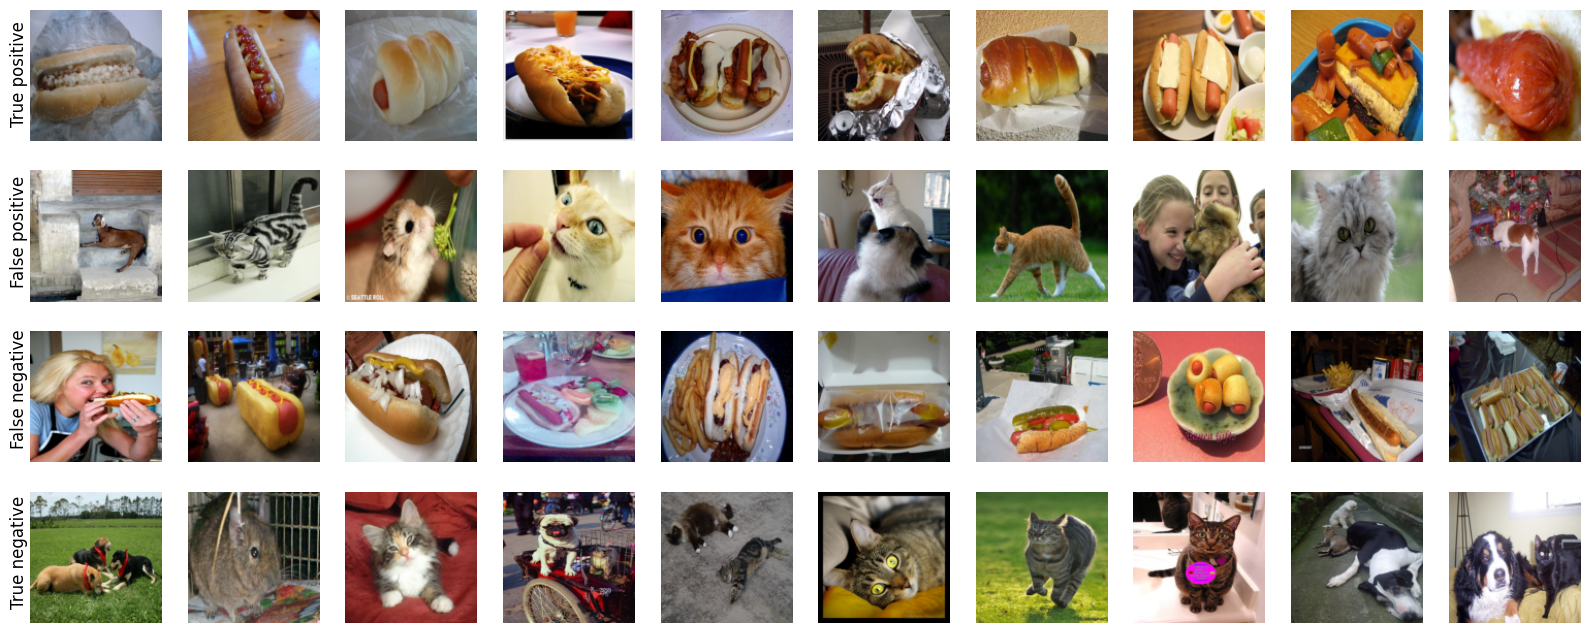

In [8]:
fig, axes = plt.subplots(4, 10, figsize=(20, 8))


for i in range(10):
    axes[0, i].imshow(tp_imgs[i])
    axes[1, i].imshow(fp_imgs[i])
    axes[2, i].imshow(fn_imgs[i])
    axes[3, i].imshow(tn_imgs[i])

for ax in axes.flat:
    ax.set_axis_off()

# Add row labels
axes[0,0].text(-20, 110, "True positive", fontsize=12, rotation=90)
axes[1,0].text(-20, 110, "False positive", fontsize=12, rotation=90)
axes[2,0].text(-20, 110, "False negative", fontsize=12, rotation=90)
axes[3,0].text(-20, 110, "True negative", fontsize=12, rotation=90)
    
plt.show()

IndexError: index 6 is out of bounds for axis 0 with size 6

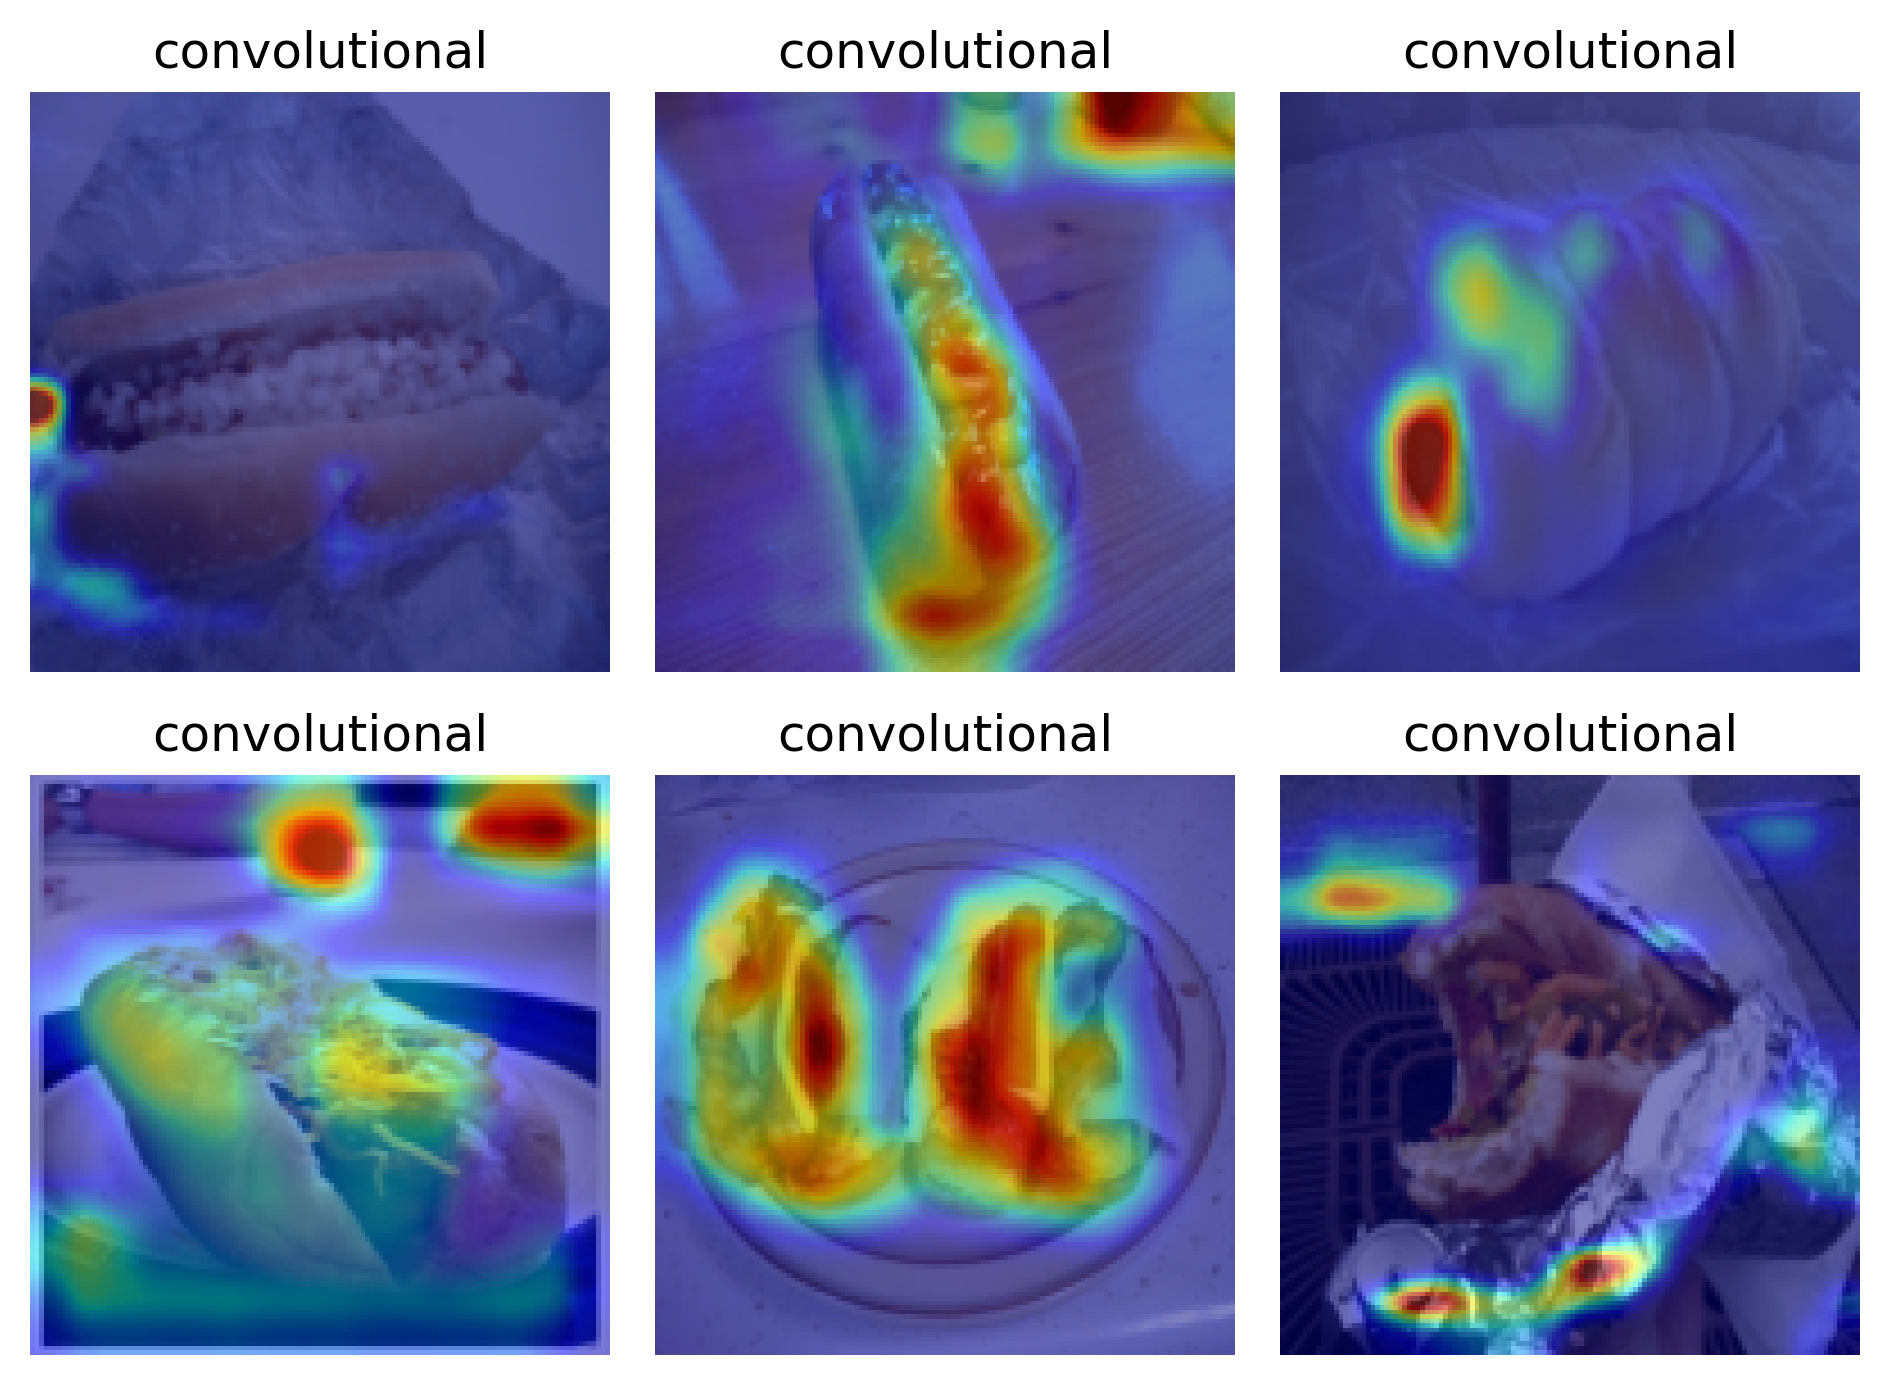

In [11]:
cam_extractor = SmoothGradCAMpp(classifier.model, target_layer='convolutional')
fig, ax = plt.subplots(2,3, dpi=300, tight_layout=True)
ax = ax.ravel()
for i, img in enumerate(data):
    imgo = Image.fromarray(tp_imgs[i].astype('uint8'))
    #input_tensor = preprocess(imgo)
    input_tensor = img
    input_batch = input_tensor.unsqueeze(0).to(device)

    out = classifier.model(input_batch)
    cams = cam_extractor(out.squeeze(0).argmax().item(), out)

    for name, cam in zip(cam_extractor.target_names, cams):
        result = overlay_mask(imgo, to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
        ax[i].imshow(result); ax[i].set_axis_off(); ax[i].set_title(name);
cam_extractor.remove_hooks()